<img src="img/h++.png" alt="HELIOS++ Logo" width="200" align="right">

# An Introduction to LiDAR Simulation with HELIOS++

**III: Evaluate AFwizard-based ground filtering with HELIOS++**

LiDAR simulation can be useful for multiple applications:
- Acquisition planning
- Method development and evaluation
- Training data generation (for machine learning)

<img src="img/lidar_sim.png" alt="Visualization of LiDAR Simulation" align="right" width="800">

In this notebook, we will use HELIOS++ for method evaluation, i.e., to assess the groundfiltering results of AFwizard with virtual "ground truth".

We have prepared an ALS scenario for virtual simulation over the 2nd study site (Monastery St. Anna & Scharfeneck Ruin, AT). We will run the simulation, which will give us a point cloud with a ground truth classification of terrain and vegetation. We can then run AFwizard with the pipeline we built before and compare the AFwizard classification with our "virtual ground truth" to evaluate the suitability of our pipeline. As such, we do not have to rely on visual expert assessment for judging our filtering pipeline but can actually quantify the filtering quality.

In [1]:
# Imports
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import pyhelios
from pyhelios import SimulationBuilder
from pyhelios.util import flight_planner
import helper_funcs
import numpy as np
import laspy
import scipy.spatial

In [2]:
# configure LAStools root
lastools_root = "D:/Software/LAStools"

## 1. Running the simulation

**Preparing the scene part files**

We first have to create a few files which we need as input to our simulation, namely:
- the terrain (as .tif GeoTIFF)
- the vegetation cover (as .xyz ASCII), which HELIOS++ will internally transform into a voxel model


In [3]:
# making sure that data/output exists before execution
Path("data/output").mkdir(parents=True, exist_ok=True)
# extracting vegetation points using LAStools and write as XYZ ASCII (text) file
!$lastools_root/bin/las2txt.exe -i data/StA_last.laz -o data/output/StA_last_vegetation.xyz -keep_classification 0 -parse xyz

**Writing the scene**

HELIOS++ uses XML files for configuring scanners, platforms, surveys and scenes. Below, we write such an XML file and fill in the values we defined before (`terrain`, `vegetation`, `voxel_size`). Note how each scene part is embedded in a `<part>` tag and uses a different "loader" `filter` depending on the file format.

In [4]:
terrain = "data/StA_last_dtm.tiff"
vegetation = "data/output/StA_last_vegetation.xyz"
voxel_size = 0.5

In [5]:
# Writing the scene XML file
scene_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<document>
    <scene id="helios_scene" name="HELIOS scene">
        
        <part>
            <filter type="geotiffloader">
                <param type="string" key="filepath" value="{terrain}" />
            </filter>
        </part>
        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="{vegetation}" />
                <param type="string" key="separator" value=" " />
                <param type="double" key="voxelSize" value="{voxel_size}" />
            </filter>
        </part>
    </scene>
</document>
"""

In [6]:
# save scene file to the current directory
scene_file = "StA_helios_scene.xml"
with open(scene_file, "w") as f:
    f.write(scene_content)

**Writing the survey**

A pre-defined survey with all relevant parameters is given below. We only enter the scene file from our Python variable.

In [7]:
from pyhelios.util import flight_planner
bbox = [19800, 312150, 20600, 312900]
waypoints, centre, distance = flight_planner.compute_flight_lines(bounding_box=bbox,
                                               spacing=260,
                                               rotate_deg=-10,
                                               flight_pattern="parallel")
# add slight random noise to each waypoint, so they are not perfectly parallel
pos_noise = np.random.uniform(-10, 10, waypoints.shape)
waypoints += pos_noise

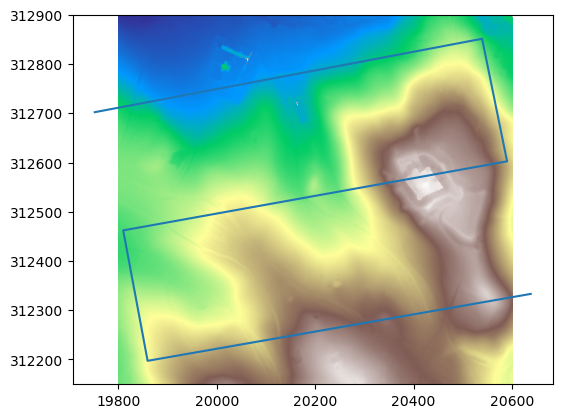

In [8]:
dtm, tf, bounds, origin_left, origin_bottom, origin_right, origin_top = helper_funcs.read_raster(terrain)
plt.imshow(dtm, cmap="terrain", extent=[origin_left, origin_right, origin_bottom, origin_top])
plt.plot(waypoints[:, 0], waypoints[:, 1])
plt.show()

In [9]:
legs = flight_planner.write_legs(waypoints, altitude=1288, template_id="scanner_als", speed="50")

In [10]:
# insert scene XML string and writing part below; see below as template
survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
    <platformSettings id="platform_als" movePerSec_m="50" />
    <scannerSettings active="true" id="scanner_als" pulseFreq_hz="100000" scanAngle_deg="45" scanFreq_hz="60" trajectoryTimeInterval_s="0.01"/>
    <survey name="als_survey_StA" platform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#riegl_lms-q560" scene="{scene_file}#helios_scene">
    <FWFSettings beamSampleQuality="5" winSize_ns="1.5"/>
    {legs}
    </survey>
</document>
''' 

In [11]:
survey_file = "als_survey_StA.xml"
with open(survey_file, 'w') as f:
    f.write(survey_content)

**Executing HELIOS++**

Now we are all set to execute HELIOS++. Since AFwizard takes a LAZ file as input, we run HELIOS++ in command line mode (rather than using the Python bindings) and then work with the written LAZ files. 

In [12]:
# todo: disable (long) output? 
!helios $survey_file --lasOutput --zipOutput --output helios_output -q

## 3. Running the AFwizard pipeline

HELIOS++ writes one file per flight line ("leg"). We first merge the flight lines to a single LAZ file and then use this LAZ file as input to AFwizard. We furthermore extract the simulated ground points by selecting the points with "hitObjectId" = 0. These will serve as our reference for AFwizard.

In [13]:
outfolder = helper_funcs.find_playback_dir(survey_file, output_folder="helios_output")

In [14]:
!$lastools_root/bin/lasmerge.exe -i $outfolder/*.laz -o data/output/helios_als_StA.laz -faf

In [15]:
!$lastools_root/bin/lasinfo.exe data/output/helios_als_StA.laz

lasinfo (241106) report for 'data/output/helios_als_StA.laz'
reporting all LAS header entries:
  file signature:             'LASF'
  file source ID:             0
  global_encoding:            0
  project ID GUID data 1-4:   00000000-0000-0000-0000-000000000000
  version major.minor:        1.4
  system identifier:          'LAStools (c) by rapidlasso GmbH'
  generating software:        'lasmerge (version 241106)'
  file creation day/year:     285/2025
  header size:                375
  offset to point data:       1197
  number var. length records: 1
  point data format:          6
  point data record length:   74
  number of point records:    0
  number of points by return: 0 0 0 0 0
  scale factor x y z:         0.0001 0.0001 0.0001
  offset x y z:               20199.874 312525.01500000001 296.58099774169921
  min x y z:                  19799.3167 312149.6271 238.2863
  max x y z:                  20600.4037 312900.4504 354.9840
  start of waveform data packet record: 0
  start o

In this LAStools window, we can see that the `hitObjectId`, which holds the information whether the point has been reflected from the ground (0) or from vegetation (1) is encoded in "attribute2". So on the following `las2las` commmand, we will drop all points with attribute `2` larger than `0` from the point cloud and write the result to a new file.

In [16]:
!$lastools_root/bin/las2las.exe -i data/output/helios_als_StA.laz -o data/output/helios_als_StA_ground_gt.laz -drop_attribute_above 2 0

Now we run AFwizard on the unfiltered point cloud with our previously created filtering pipeline.

In [17]:
# run AFwizard on simulated point cloud
!afwizard --dataset=data/output/helios_als_StA.laz --dataset-crs=EPSG:31256 --segmentation=data/StA_segments_assigned.geojson --segmentation-crs=EPSG:31256 --output-dir=data/output --library filters --lastools-dir=$lastools_root

D:\Software\micromamba\envs\groundfiltering\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


We will find this point cloud in the `output` folder as `helios_als_StA_filtered.las` and will run a similar command on it, but this time using the `classification` value and keeping only the value `2`.

In [18]:
!$lastools_root/bin/las2las.exe -i data/output/helios_als_StA_filtered.las -o data/output/helios_als_StA_ground_afwizard.laz -keep_classification 2

## 4. Comparison of AFwizard output with ground truth

In [19]:
output_afwizard = "data/output/helios_als_StA_ground_afwizard.laz"
output_gt = "data/output/helios_als_StA_ground_gt.laz"

In [20]:
# read with laspy
las = laspy.read(output_afwizard)
pc_afwizard = np.array([las.x, las.y, las.z]).T
las = laspy.read(output_gt)
pc_gt = np.array([las.x, las.y, las.z]).T

In [21]:
# difference in number of points
diff = pc_gt.shape[0] - pc_afwizard.shape[0]
print(f"Difference in number of points: {diff} (= {diff/pc_gt.shape[0] * 100:.1f}%)")

Difference in number of points: 19197 (= 1.8%)


In [22]:
# calculate overlap ratio
def overlap_ratio(pc1, pc2, inlier_threshold=0.001):
    # get distance to closest point
    kdtree = scipy.spatial.KDTree(pc1)
    d, i = kdtree.query(pc2, k=1)
    # evaluate whether inlier or not
    inlier_count = np.sum(d < inlier_threshold)
    # compute overlap_ratio
    overlap_ratio = inlier_count / pc2.shape[0]
    
    outliers = pc2[d > inlier_threshold]
    
    return overlap_ratio, outliers

In [23]:
o_ratio, outliers = overlap_ratio(pc_afwizard, pc_gt, inlier_threshold=0.01)
print(f"Overlap ratio for threshold = 0.01: {o_ratio*100:.2f}%")

Overlap ratio for threshold = 0.01: 98.17%


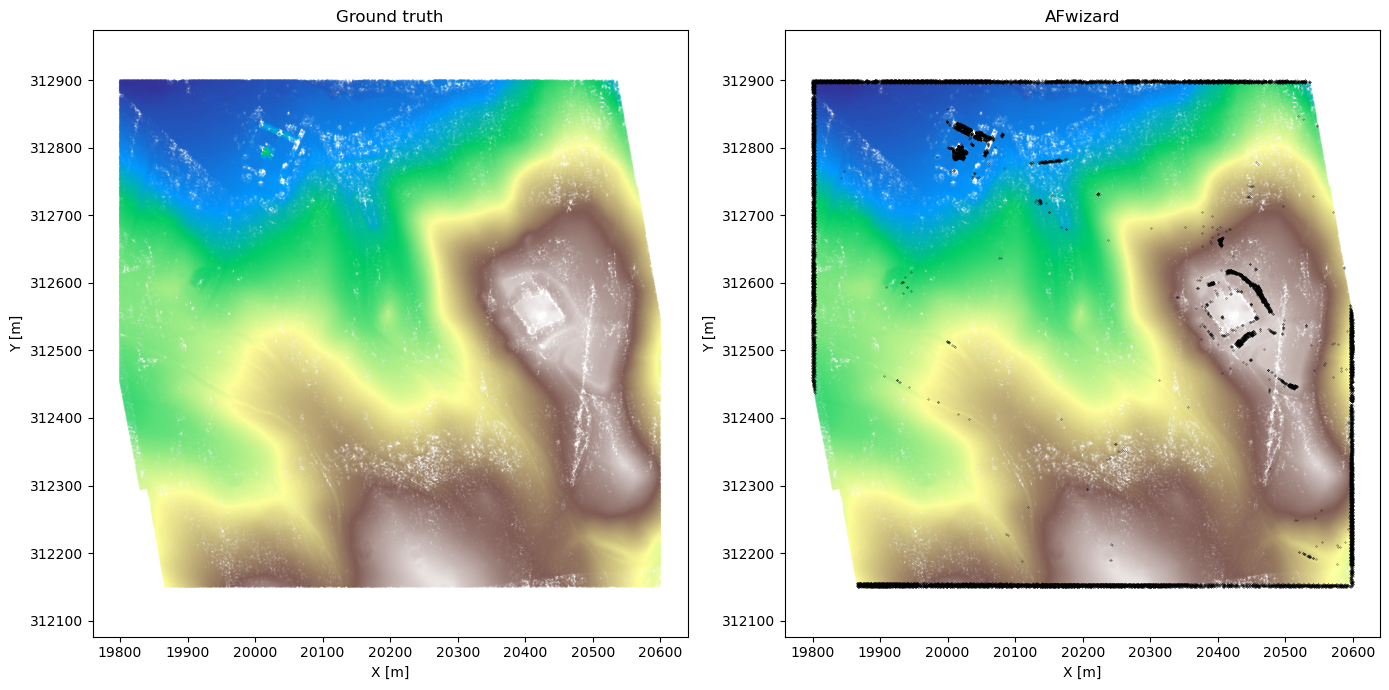

In [24]:
# visualize side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

for pc, ax, title in zip([pc_gt, pc_afwizard], [ax1, ax2], ["Ground truth", "AFwizard"]):
    ax.scatter(pc[:, 0], pc[:, 1], c=pc[:, 2], s=0.02, cmap="terrain")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.axis('equal')
    ax.set_title(title)

ax2.scatter(outliers[:, 0], outliers[:, 1], c="black", s=0.05)
plt.tight_layout()
plt.show()

The black points on the left show which points were not correctly filtered by the AFwizard pipeline.